<a href="https://colab.research.google.com/github/nwon24/basel/blob/main/Basel_LSTM_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset,DataLoader,TensorDataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from datetime import date

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file="/content/drive/MyDrive/Colab Notebooks/Basel_2020-23.csv"
file2="/content/drive/MyDrive/Colab Notebooks/Basel_2024-25.csv"
#file="/content/drive/MyDrive/Colab Notebooks/Basel_2001-25.csv"

df=pd.read_csv(file,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
df2=pd.read_csv(file2,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
nparr=df.to_numpy(dtype=np.float64)
nparr2=df2.to_numpy(dtype=np.float64)


In [4]:
predwin=8
testhours=365*24
horizon=16
totalhours=nparr.size
train_split=nparr[:-testhours]
test_split=nparr[-testhours:]
valid_split=nparr2


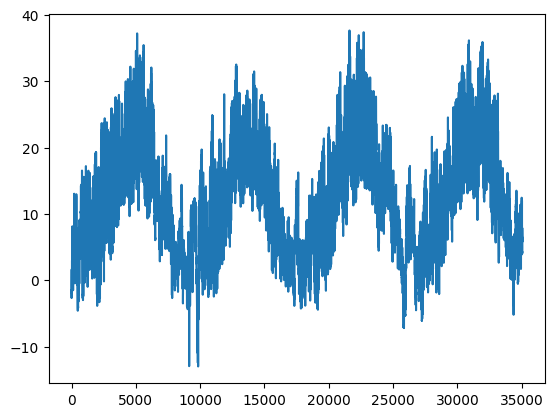

In [5]:
plt.plot(np.arange(totalhours),nparr)
plt.show()

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
#scaler=MinMaxScaler(feature_range=(-1,1))
train_data=(torch.from_numpy(scaler.fit_transform(train_split)))
test_data=(torch.from_numpy(scaler.transform(test_split)))
valid_data=(torch.from_numpy(scaler.transform(valid_split)))

In [7]:
def preparexy(data,predwin,horizon):
    n=(len(data)-predwin)//horizon
    x=torch.zeros((n,predwin,1))
    y=torch.zeros((n,horizon,1))
    for i in range(n):
        x[i]=data[i:i+predwin]
        y[i]=data[i+predwin:i+predwin+horizon]
    return x,y

xtrain,ytrain=preparexy(train_data,predwin,horizon)
xtest,ytest=preparexy(test_data,predwin,horizon)
xvalid,yvalid=preparexy(valid_data,predwin,horizon)

In [8]:
class lstm(nn.Module):
    def __init__(self,inputsize,hiddensize,nlayers,outputsize,batch_first=True,dropout=0.0):
        super().__init__()
        self.inputsize=inputsize
        self.hiddensize=hiddensize
        self.nlayers=nlayers
        self.batch_first=batch_first
        self.outputsize=outputsize
        self.dropout=dropout
        self.lstm=nn.LSTM(self.inputsize,self.hiddensize,self.nlayers,batch_first=self.batch_first,dropout=dropout)
        self.linear=nn.Linear(self.hiddensize,outputsize)

    def forward(self,x):
        out,_=self.lstm(x)
        return self.linear(out[:,-1,:])

In [9]:
inputsize=1
nlayers=1
hiddensize=128
outputsize=horizon

dropout=0.0
lr=1e-3

model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)
lossfn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


In [10]:
batch_size=64
epochs=50

traindataset=TensorDataset(xtrain,ytrain)
trainloader=DataLoader(traindataset,batch_size=batch_size,shuffle=True)
testdataset=TensorDataset(xtest,ytest)
testloader=DataLoader(testdataset,batch_size=batch_size,shuffle=True)

In [ ]:
print(xvalid.size(),yvalid.size())
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

torch.Size([1096, 8, 1]) torch.Size([1096, 16, 1])
69136


In [11]:
def validate(model,xvalid,yvalid,shape,predwin,horizon,start=None,end=None):
    nhours=xvalid.numel()
    n=len(xvalid)
    t=np.arange(nhours)
    forecasts=[]
    for i in range(n):
        y=model(xvalid[i].reshape(shape))
        forecasts.append(y.detach().numpy())
    if end is None:
        end=nhours
    if start is None:
        start=0
    forecasts=np.array(forecasts).flatten()
    transformed_forecasts=scaler.inverse_transform(forecasts.reshape(-1,1))
    transformed_y=scaler.inverse_transform(yvalid.detach().numpy().reshape(-1,1))
    plt.figure()
    plt.plot(t[start:end],transformed_forecasts[start:end],label="Predicted")
    plt.plot(t[start:end],transformed_y[start:end],label="Actual")
    plt.legend(loc="best")
    plt.show()
    return r2_score(transformed_y[start:end],transformed_forecasts[start:end])

In [ ]:
for epoch in range(epochs):
    model.train()
    trainloss=0.0
    testloss=0.0
    for x,y in trainloader:
        pred=model(x)
        loss=lossfn(pred,y.reshape(pred.shape))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    model.eval()
    with torch.no_grad():
        for x,y in testloader:
            pred=model(x)
            loss=lossfn(pred,y.reshape(pred.shape))
            testloss+=loss.item()

    print(f"Epoch {epoch}: avg train loss = {trainloss/len(trainloader):.5f}, avg test loss = {testloss/len(testloader):.5f}")
    if (epoch+1)%5==0 and epoch>0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/Basel_LSTM_{date.today()}_{epoch}e_{horizon}h_{nlayers}l.pth")


Epoch 0: avg train loss = 0.05845, avg test loss = 0.00944
Epoch 1: avg train loss = 0.00829, avg test loss = 0.00587
Epoch 2: avg train loss = 0.00692, avg test loss = 0.00554
Epoch 3: avg train loss = 0.00659, avg test loss = 0.00505
Epoch 4: avg train loss = 0.00622, avg test loss = 0.00458
Epoch 5: avg train loss = 0.00582, avg test loss = 0.00396
Epoch 6: avg train loss = 0.00540, avg test loss = 0.00298
Epoch 7: avg train loss = 0.00523, avg test loss = 0.00300
Epoch 8: avg train loss = 0.00510, avg test loss = 0.00275
Epoch 9: avg train loss = 0.00493, avg test loss = 0.00267
Epoch 10: avg train loss = 0.00495, avg test loss = 0.00274
Epoch 11: avg train loss = 0.00484, avg test loss = 0.00268
Epoch 12: avg train loss = 0.00500, avg test loss = 0.00302
Epoch 13: avg train loss = 0.00492, avg test loss = 0.00269
Epoch 14: avg train loss = 0.00483, avg test loss = 0.00278
Epoch 15: avg train loss = 0.00483, avg test loss = 0.00285
Epoch 16: avg train loss = 0.00478, avg test loss 

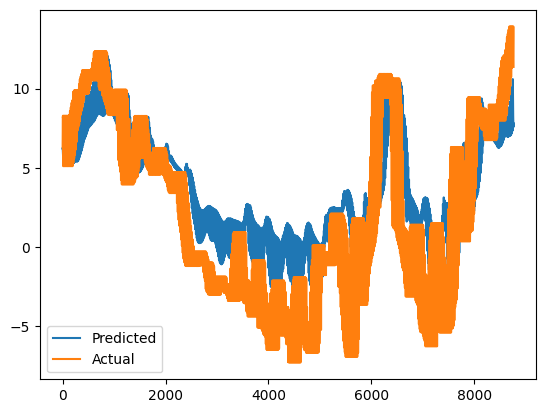

0.5539828538894653

In [ ]:
validate(model,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)

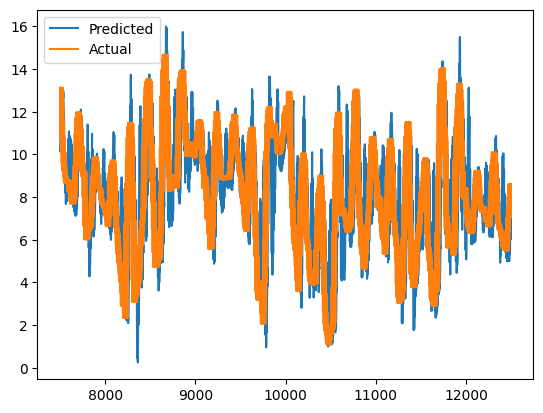

0.35459810495376587

In [ ]:
validate(model,xvalid,yvalid,(1,-1,1),predwin,horizon,start=7500,end=12500)

In [12]:
!pip install pennylane
import pennylane as qml
#!pip install pennylane-lightning-gpu
#!pip install custatevec_cu12
#!pip install custatevec-cu11
#!pip install quimb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 99.1 MB/s eta 0:00:00


In [22]:
qpredwin=predwin
qhorizon=horizon
qoutputsize=outputsize
nqubits=qpredwin
#qdev="lightning.gpu"
#qdev="default.qubit"
qdev="lightning.qubit"
dev=qml.device(qdev,wires=nqubits)
#dev=qml.device("default.qubit",wires=nqubits)
nlayers=5

@qml.qnode(dev)
def qnode(inputs,weights):
    #print(inputs.shape)
    for i in range(nqubits):
        qml.Hadamard(wires=i)
        qml.RY(inputs[i],wires=i)
    #for i in range(len(inputs)):
    #    qml.RY(inputs[i],wires=i%nqubits)
    #qml.AmplitudeEmbedding(inputs,wires=range(nqubits),pad_with=0,normalize=True)

    for i in range(nlayers):
        for j in range(nqubits-1):
            qml.CNOT(wires=[j,j+1])
        qml.CNOT(wires=[0,nqubits-1])
        for j in range(nqubits):
            qml.Rot(*weights[i][j],wires=j)
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]

In [23]:
weightshapes={"weights": (nlayers,nqubits,3)}
qlayer=qml.qnn.TorchLayer(qnode,weightshapes)

In [24]:
class qmodel(nn.Module):
    def __init__(self,outputsize):
        super().__init__()
        self.qlayer=qlayer
        self.outputsize=outputsize
        self.lin=nn.Linear(nqubits,outputsize)

    def forward(self,x):
        y=self.qlayer(x)
        #print(y.shape)
        return self.lin(y)



In [25]:
qnn=qmodel(qoutputsize)

In [ ]:
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-01-28_44e_4l.pth",weights_only=True))

<All keys matched successfully>

In [26]:
print(sum(p.numel() for p in qnn.parameters() if p.requires_grad))

264


In [27]:
qbatch_size=1
qxtrain,qytrain=preparexy(train_data,qpredwin,qhorizon)
qxtest,qytest=preparexy(test_data,qpredwin,qhorizon)
qtraindataset=TensorDataset(qxtrain,qytrain)
qlr=0.1
qtrainloader=DataLoader(qtraindataset,batch_size=qbatch_size,shuffle=True)
qtestdataset=TensorDataset(qxtest,qytest)
qtestloader=DataLoader(qtestdataset,batch_size=qbatch_size,shuffle=True)

In [28]:
qoptimizer=torch.optim.Adam(qnn.parameters(),lr=lr)

In [29]:
for epoch in range(epochs):
    qnn.train()
    trainloss=0.0
    testloss=0.0
    for x,y in qtrainloader:
        pred=qnn(x.flatten())
        #print(pred.shape)
        loss=lossfn(pred,y.reshape(pred.shape))
        qoptimizer.zero_grad()
        loss.backward()
        qoptimizer.step()
        trainloss+=loss.item()

    qnn.eval()
    with torch.no_grad():
        for x,y in qtestloader:
            pred=qnn(x.flatten())
            loss=lossfn(pred,y.reshape(pred.shape))
            testloss+=loss.item()

    print(f"Epoch {epoch}: avg train loss = {trainloss/len(trainloader):.5f}, avg test loss = {testloss/len(testloader):.5f}")
    if (epoch+1)%5==0 and epoch>0:
        torch.save(qnn.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_{date.today()}_{epoch}e_{qhorizon}h_{nlayers}l.pth")


Epoch 0: avg train loss = 1.17709, avg test loss = 0.22525
Epoch 1: avg train loss = 0.34463, avg test loss = 0.16416
Epoch 2: avg train loss = 0.32265, avg test loss = 0.14230
Epoch 3: avg train loss = 0.30860, avg test loss = 0.14797
Epoch 4: avg train loss = 0.30032, avg test loss = 0.13123
Epoch 5: avg train loss = 0.28782, avg test loss = 0.14953
Epoch 6: avg train loss = 0.28056, avg test loss = 0.13886
Epoch 7: avg train loss = 0.27276, avg test loss = 0.12771
Epoch 8: avg train loss = 0.26891, avg test loss = 0.14062
Epoch 9: avg train loss = 0.26199, avg test loss = 0.14697
Epoch 10: avg train loss = 0.26124, avg test loss = 0.12436
Epoch 11: avg train loss = 0.25943, avg test loss = 0.11930
Epoch 12: avg train loss = 0.25504, avg test loss = 0.13137
Epoch 13: avg train loss = 0.25378, avg test loss = 0.14068
Epoch 14: avg train loss = 0.25326, avg test loss = 0.12802
Epoch 15: avg train loss = 0.25166, avg test loss = 0.12564
Epoch 16: avg train loss = 0.25158, avg test loss 

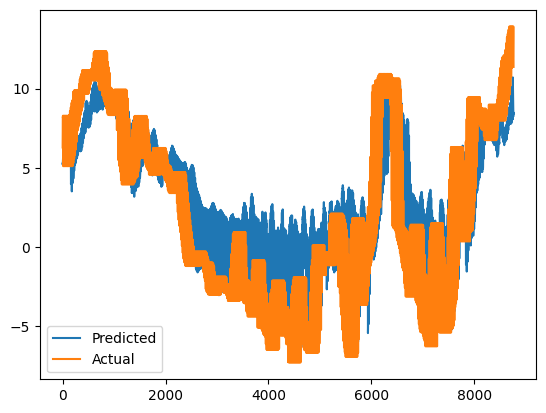

0.5892398953437805

In [30]:
# 5 layers
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

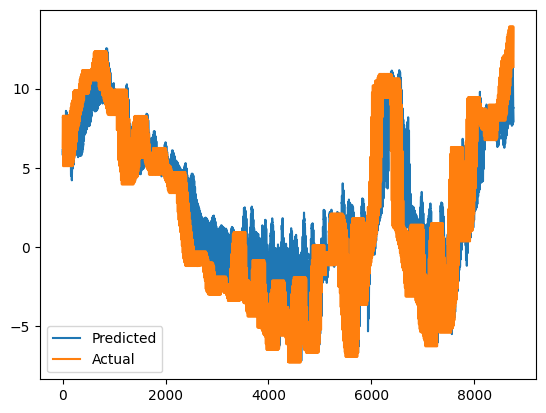

0.6476117968559265

In [21]:
# 4 layers
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

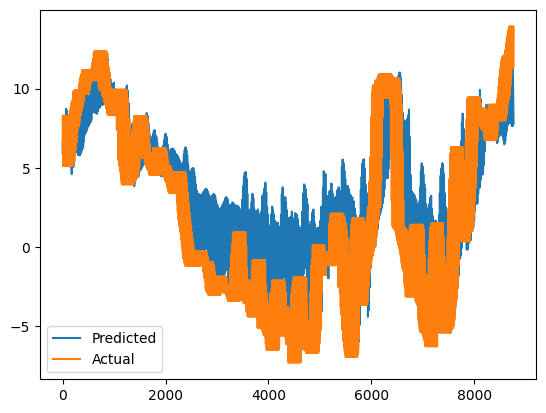

0.5146890878677368

In [ ]:
# 3 layers
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

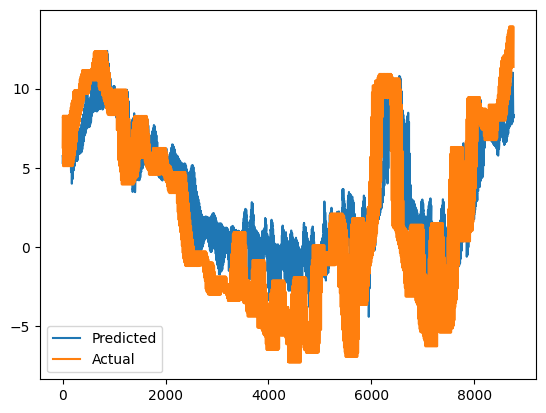

0.6139172911643982

In [ ]:
# 2 layers
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

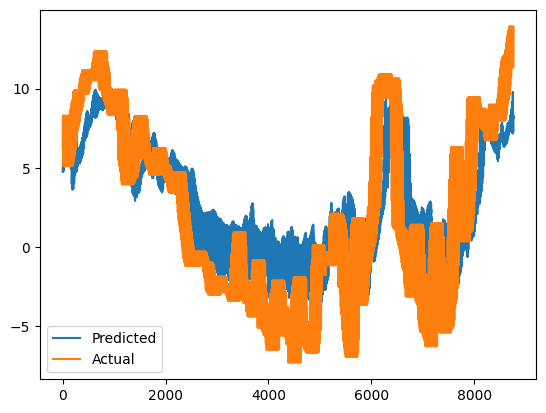

0.5834752321243286

In [ ]:
# 1 layer
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

In [ ]:
print(qnn(xvalid[0].reshape(-1)))
print(yvalid[0])

tensor([0.3913, 0.3973, 0.4051, 0.4069, 0.4110, 0.4137, 0.4141, 0.4164],
       grad_fn=<ViewBackward0>)
tensor([[0.3808],
        [0.3917],
        [0.4033],
        [0.4162],
        [0.4187],
        [0.4183],
        [0.4203],
        [0.4162]])
